In [1]:
import math as m
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
import matplotlib

SMALL_SIZE = 15
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE, labelsize=SMALL_SIZE)

In [2]:
# Exact parameters fit for each dose
doses_data_all = np.array([0.032, 0.1, 0.32, 1, 3.2]);
doses_data_sub = np.array([0.032, 0.32, 3.2]);

# Fits across all 5 doses
r_S_fit_all = np.array([0.0532, 0.0630, 0.0722, 0.0539, 0.0880])
d_S_fit_all = np.array([0.1855, 0.3394, 0.4012, 0.2862, 0.6924])
alpha_fit_all = np.array([0.2520, 0.2155, 0.1963, 0.1378, 0.1048])
r_R_fit_all = np.array([0.0532, 0.0519, 0.0415, 0.0190, 0.0070])
d_R_fit_all = np.array([0.0751, 0.0819, 0.0699, 0.0339, 0.0137])

# Fits only at doses_data_sub
r_S_fit_sub = np.array([0.0532, 0.0722, 0.0880])
d_S_fit_sub = np.array([0.1855, 0.4012, 0.6924])
alpha_fit_sub = np.array([0.2520, 0.1963, 0.1048])
r_R_fit_sub = np.array([0.0532, 0.0415, 0.0070])
d_R_fit_sub = np.array([0.0751, 0.0699, 0.0137])

# Plot the data fits, the piecewise linear interpolated values (using doses_data_sub), and the fit polynomial
# Recall that we interpolate on the log scale
r_S_lin_inter = np.interp(np.log10(doses_data_all), np.log10(doses_data_sub), r_S_fit_sub)
d_S_lin_inter = np.interp(np.log10(doses_data_all), np.log10(doses_data_sub), d_S_fit_sub)
alpha_lin_inter = np.interp(np.log10(doses_data_all), np.log10(doses_data_sub), alpha_fit_sub)
r_R_lin_inter = np.interp(np.log10(doses_data_all), np.log10(doses_data_sub), r_R_fit_sub)
d_R_lin_inter = np.interp(np.log10(doses_data_all), np.log10(doses_data_sub), d_R_fit_sub)

# Now evaluate the polynomial
# First define helper functions to define the polynomial
def coeff_poly_fit(x_data, y_data, deg=None):
    # Find coefficients that fit (x_data, y_data) of a given degree deg
    # x_data:  x coordinates of data (numpy array)
    # y_data:  y coordinates of data (numpy array)
    # deg:  degree of polynomial to fit (default is interpolation)
    # x_data and y_data must have equal length
    # Returns coefficients for corresponding polynomial

    # No degree provided, then use interpolation
    if deg is None:
        deg = len(x_data) - 1
    fit = np.polynomial.polynomial.Polynomial.fit(x_data, y_data, deg)
    coeff = fit.convert().coef  # Get the coefficients
    return coeff[::-1]          # Return coefficients in correct order for polyval

def poly_fun(x, coeffs):
    # Evaluate the polyomial at x with given coefficients
    # x:  point of evaluation
    # coeffs:  coefficients defining polyomial (starts at highest degree)
    if type(x) is ca.casadi.MX:
        coeffs_casadi = ca.MX(coeffs)
        return ca.polyval(coeffs_casadi, x)
    else:
        return np.polyval(coeffs, x)

# Fit the coeffiients for each each parameter function
# Pick a degree and fit
deg_r_S = 3
r_S_coeffs = coeff_poly_fit(np.log10(doses_data_all), r_S_lin_inter, deg=deg_r_S)

deg_d_S = 3
d_S_coeffs = coeff_poly_fit(np.log10(doses_data_all), d_S_lin_inter, deg=deg_d_S)

deg_alpha = 3
alpha_coeffs = coeff_poly_fit(np.log10(doses_data_all), alpha_lin_inter, deg=deg_alpha)

deg_r_R = 3
r_R_coeffs = coeff_poly_fit(np.log10(doses_data_all), r_R_lin_inter, deg=deg_r_R)

deg_d_R = 3
d_R_coeffs = coeff_poly_fit(np.log10(doses_data_all), d_R_lin_inter, deg=deg_d_R)

In [3]:
# Delay parameters not functions of dose
gamma1 = 0.01
gamma2 = 0.01

# Bounds on u
u_min = 0.032
u_max = 3.2

# Bounds on u_tilde
u_tilde_min = np.log10(u_min)
u_tilde_max = np.log10(u_max)

# Define the vector field dx_dt = f(t,x,u)

# Test to make sure forward RK method agrees with paper
def vector_field(t, x, u_tilde):
    S = x[0]
    R = x[1]
    v_dS = x[2]
    v_dR = x[3]
    v_alpha = x[4]
    z = x[5]

    r_S = poly_fun(u_tilde, r_S_coeffs)
    d_S = poly_fun(u_tilde, d_S_coeffs)
    alpha = poly_fun(u_tilde, alpha_coeffs)
    r_R = poly_fun(u_tilde, r_R_coeffs)
    d_R = poly_fun(u_tilde, d_R_coeffs)

    dS_dt = r_S * S - v_dS * S - v_alpha * S
    dR_dt = r_R * R + v_alpha * S - v_dR * R
    dv_dS_dt = gamma1 * (d_S - v_dS)
    dv_dR_dt = gamma1 * (d_R - v_dR)
    dv_alpha_dt = gamma2 * (alpha - v_alpha)
    dz_dt = 10 ** u_tilde

    if type(S) is ca.casadi.MX:
        return ca.vertcat(dS_dt, dR_dt, dv_dS_dt, dv_dR_dt, dv_alpha_dt, dz_dt)
    else:
        return np.array([dS_dt, dR_dt, dv_dS_dt, dv_dR_dt, dv_alpha_dt, dz_dt])


In [4]:
# Define an integrator
# For simplicity, use RK 4 (explicit)

def integrator(f, t, x, u, dt):
    # Integrates one step of dx_dt = f(t,x,u)
    # Meaning:  integrates from t to t+dt
    # Using values x = x(t) and u = u(t) to compute x(t+dt)
    # Use RK4

    k1 = f(t, x, u)
    k2 = f(t + dt / 2, x + dt / 2 * k1, u)
    k3 = f(t + dt / 2, x + dt / 2 * k2, u)
    k4 = f(t + dt, x + dt * k3, u)

    return x + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

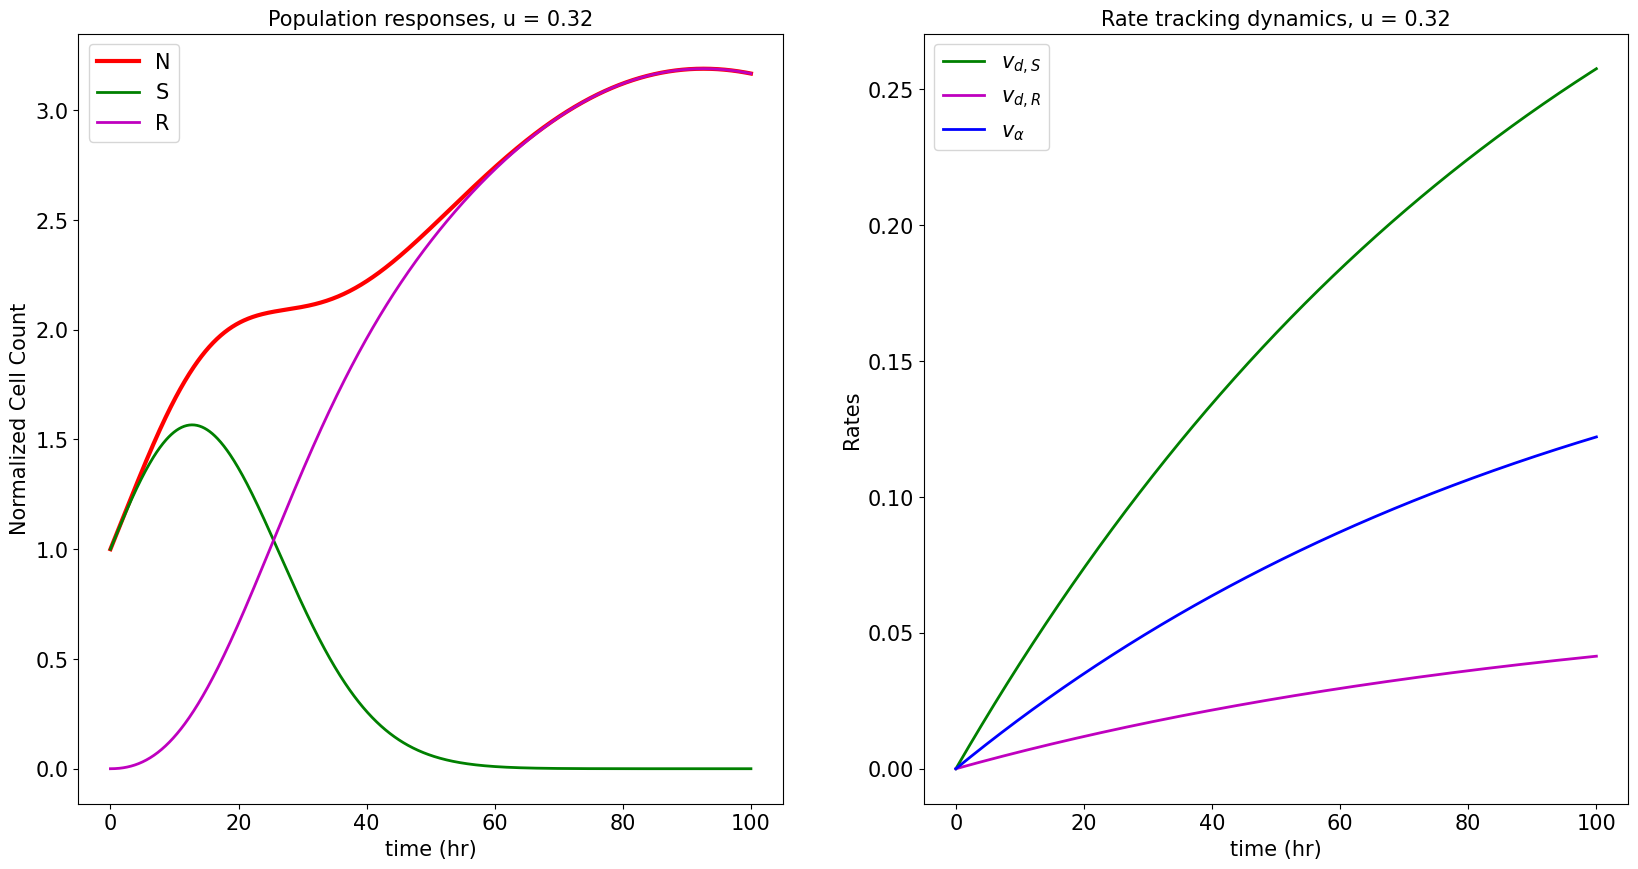

Final tumor volume for constant dose of u = 0.32:  3.166687639921118


In [5]:
#Test on a sample IVP, to verify that the integrator is working properly.
# Solve the IVP corresponding to constant dose u_const
u_const = 0.32
u_tilde_const = np.log10(u_const)
u_tilde_fun = lambda t: u_tilde_const

# Time to solve on
t0 = 0
tf = 100
num_control_intervals = 1000  # number of time steps
dt = (tf - t0) / num_control_intervals

# Arrays to store solution
t = np.linspace(t0, tf, num_control_intervals)
x = np.zeros((num_control_intervals, 6))
u = np.vectorize(u_tilde_fun)(t)

# Initial conditions
S0 = 1
R0 = 0
v_dS0 = 0
v_dR0 = 0
v_alpha0 = 0
z0 = 0        # Auxilliary variable for constraint of total dose

x[0, :] = np.array([S0, R0, v_dS0, v_dR0, v_alpha0, z0])

# Update x via integrator
for k in range(num_control_intervals - 1):
    x[k+1, :] = integrator(vector_field, t[k], x[k, :], u[k], dt)

S = x[:, 0]
R = x[:, 1]
v_dS = x[:, 2]
v_dR = x[:, 3]
v_alpha = x[:, 4]
z = x[:, 5]
N = S + R

# Plot results
# Plot both populations (S,R, and N) and tracking rates (v_dS, v_dR, and v_alpha)
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.5)

plt.subplot(1, 2, 1)
plt.plot(t, N, label='N', linewidth=3, color='r')
plt.plot(t, S, label='S', linewidth=2, color='g')
plt.plot(t, R, label='R', linewidth=2, color='m')
plt.legend(loc='best')
plt.xlabel('time (hr)')
plt.ylabel('Normalized Cell Count')
plt.title('Population responses, u = ' + str(u_const))

plt.subplot(1, 2, 2)
plt.plot(t, v_dS, label=r'$v_{d,S}$', linewidth=2, color='g')
plt.plot(t, v_dR, label=r'$v_{d,R}$', linewidth=2, color='m')
plt.plot(t, v_alpha, label=r'$v_{\alpha}$', linewidth=2, color='blue')
plt.legend(loc='best')
plt.xlabel('time (hr)')
plt.ylabel('Rates')
plt.title('Rate tracking dynamics, u = ' + str(u_const))

plt.show()

print(f'Final tumor volume for constant dose of u = {u_const}:  {N[-1]}')

In [6]:
#Now we attempt to solve the optimal control problem.
# Total dosage constraint
M = 100

# Now try and solve the optimization problem
opti = ca.Opti()

x = opti.variable(6, num_control_intervals)
S = x[0, :]
R = x[1, :]
v_dS = x[2, :]
v_dR = x[3, :]
v_alpha = x[4, :]
z = x[5, :]

u_tilde = opti.variable(1, num_control_intervals)
t = opti.variable(1, num_control_intervals)

# Objective
opti.minimize(S[-1] + R[-1])

# Discretize solver (add gap-closing constraints)
for k in range(num_control_intervals - 1):
    x_next = integrator(vector_field, t[k], x[:, k], u_tilde[k], dt)
    opti.subject_to(x[:, k+1] == x_next)
    # Update time as well
    opti.subject_to(t[k+1] == t[k] + dt)

# Set boundary constraints
opti.subject_to(t[0] == t0)
opti.subject_to(S[0] == S0)
opti.subject_to(R[0] == R0)
opti.subject_to(v_dS[0] == v_dS0)
opti.subject_to(v_dR[0] == v_dR0)
opti.subject_to(v_alpha[0] == v_alpha0)
opti.subject_to(z[0] == z0)
opti.subject_to(z[-1] <= M)

# Boundary conditions on u between lowest and highest dose
opti.subject_to(opti.bounded(u_tilde_min, u_tilde, u_tilde_max))

# Initial values for solver
opti.set_initial(u_tilde, M / tf)

p_opts = {"expand": True}
s_opts = {"max_iter": 5000}

opti.solver('ipopt', p_opts, s_opts)
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    25981
Number of nonzeros in inequality constraint Jacobian.:     1001
Number of nonzeros in Lagrangian Hessian.............:    15984

Total number of variables............................:     8000
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     7000
Total number of inequality c

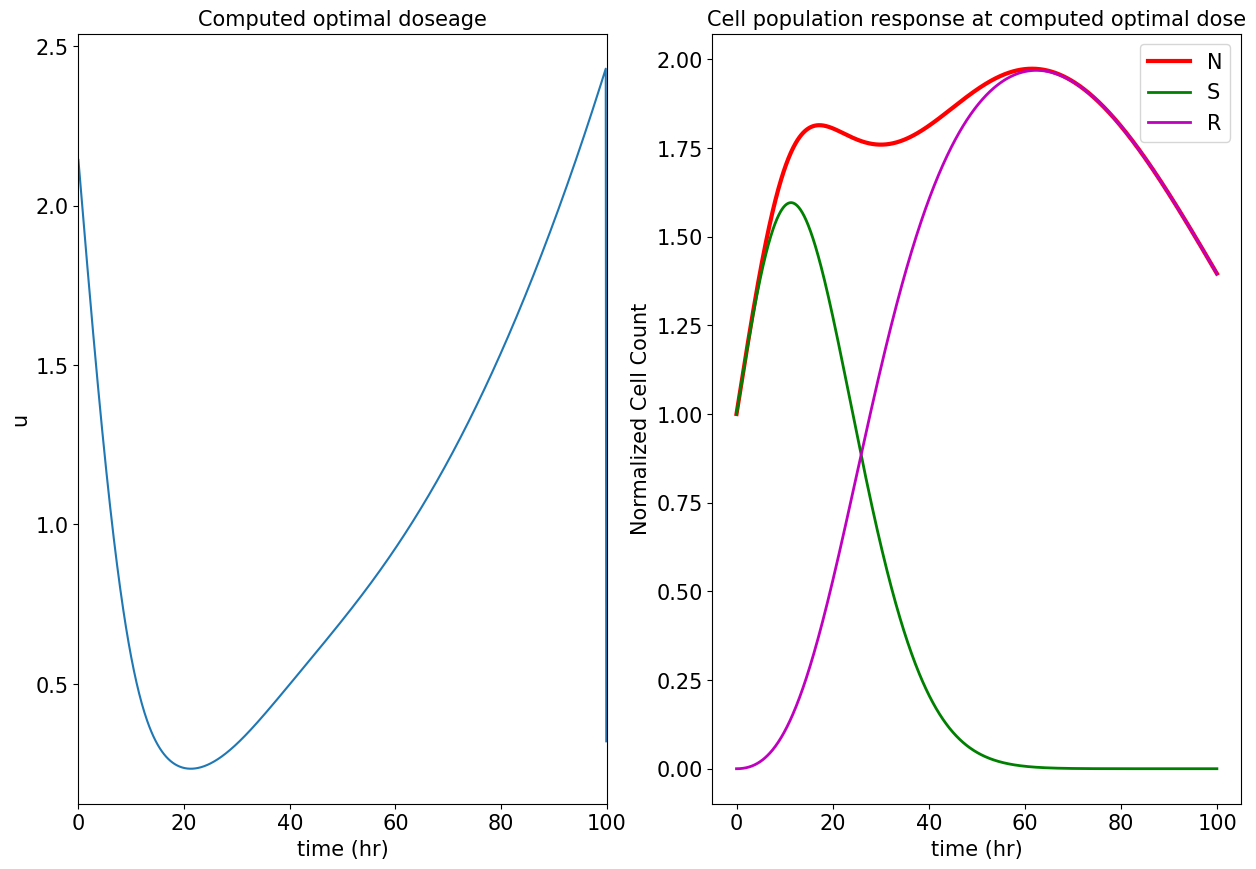

Final tumor volume:   1.3958480037567147
Total drug applied from z:   100.00000075085018
Total drug applied from numerical integration:   99.90884731468515


In [7]:
#Once run, we output the solution structure and plot the results.
time_vec =sol.value(t)

u_tilde_sol = sol.value(u_tilde)
S_sol = sol.value(S)
R_sol = sol.value(R)
v_dS_sol = sol.value(v_dS)
v_dR_sol = sol.value(v_dR)
v_alpha_sol = sol.value(v_alpha)

N_sol = S_sol + R_sol
z_sol = sol.value(z)

# Convert u_tilde to u
u_sol = 10 ** u_tilde_sol

# Also check on value of total applied drug
total_drug_applied_z = z_sol[-1]
total_drug_applied_integrate = np.trapz(u_sol, x=time_vec)

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.plot(time_vec, u_sol)
plt.xlabel('time (hr)')
plt.ylabel('u')
plt.xlim((t0, tf))
plt.title('Computed optimal doseage')

plt.subplot(1, 2, 2)
plt.plot(time_vec, N_sol, label='N', linewidth=3, color='r')
plt.plot(time_vec, S_sol, label='S', linewidth=2, color='g')
plt.plot(time_vec, R_sol, label='R', linewidth=2, color='m')
plt.legend(loc='best')
plt.xlabel('time (hr)')
plt.ylabel('Normalized Cell Count')
plt.title('Cell population response at computed optimal dose')

plt.show()

final_tumor_volume = S_sol[-1] + R_sol[-1]

print('Final tumor volume:  ', str(final_tumor_volume))
print('Total drug applied from z:  ', str(total_drug_applied_z))
print('Total drug applied from numerical integration:  ', str(total_drug_applied_integrate))

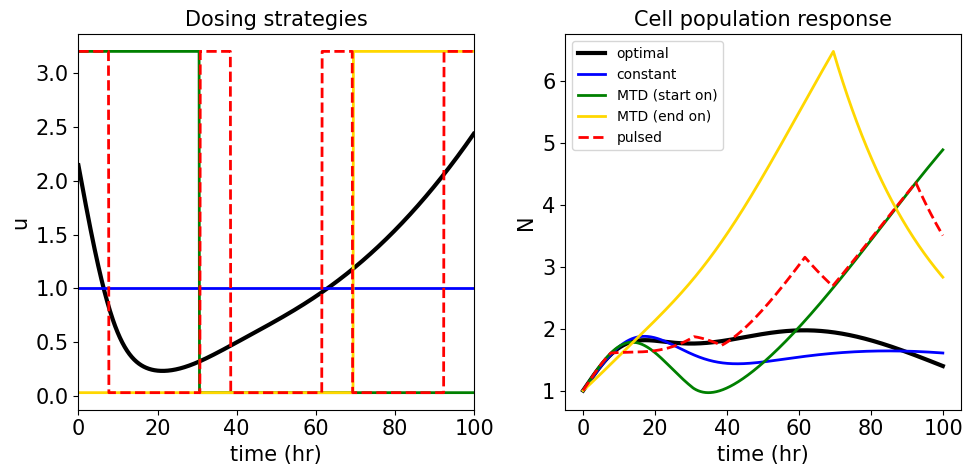

In [8]:
#Now we compare the computed optimal to both constant and MTD (initial MTD, where we apply the maximum dose for as long as we can).

# First, fix the end of the compluted optimal solution
u_sol_fix_end = 2 * u_sol[-2] - u_sol[-3]
u_sol[-1] = u_sol_fix_end

# A constant dose
u_constant = np.minimum(M / tf, u_max)
u_tilde_constant = np.log10(u_constant)
u_tilde_constant_fun = lambda t: u_tilde_constant

x_constant = np.zeros((num_control_intervals, 6))
u_tilde_constant_vec = np.vectorize(u_tilde_constant_fun)(time_vec)
u_constant_vec = 10 ** u_tilde_constant_vec

# Initial conditions
x_constant[0, :] = np.array([S0, R0, v_dS0, v_dR0, v_alpha0, z0])

# Update x via integrator
for k in range(num_control_intervals - 1):
    x_constant[k+1, :] = integrator(vector_field, time_vec[k], x_constant[k, :], u_tilde_constant_vec[k], dt)

S_constant = x_constant[:, 0]
R_constant = x_constant[:, 1]
v_dS_constant = x_constant[:, 2]
v_dR_constant = x_constant[:, 3]
v_alpha_constant = x_constant[:, 4]
z_constant = x_constant[:, 5]
N_constant = S_constant + R_constant

# Also test against maximum dose for as long as possible
t_switch = (M - u_min * tf) / (u_max - u_min)

def u_tilde_MTD(t):
    if t <= t_switch:
        u_tilde = np.log10(u_max)
    else:
        u_tilde = np.log10(u_min)
        
    return u_tilde

u_tilde_MTD_vec = np.vectorize(u_tilde_MTD)(time_vec)
u_MTD_vec = 10 ** u_tilde_MTD_vec

x_MTD = np.zeros((num_control_intervals, 6))

# Initial conditions
x_MTD[0, :] = np.array([S0, R0, v_dS0, v_dR0, v_alpha0, z0])

# Update x via integrator
for k in range(num_control_intervals - 1):
    x_MTD[k+1, :] = integrator(vector_field, time_vec[k], x_MTD[k, :], u_tilde_MTD_vec[k], dt)

S_MTD = x_MTD[:, 0]
R_MTD = x_MTD[:, 1]
v_dS_MTD = x_MTD[:, 2]
v_dR_MTD = x_MTD[:, 3]
v_alpha_MTD = x_MTD[:, 4]
z_MTD = x_MTD[:, 5]
N_MTD = S_MTD + R_MTD

# Now try and figure out a pulsed therapy protocol
del_t_min = (u_max * tf - M) / (3 * (u_max - u_min))
del_t_max = (M - u_min * tf) / (4 * (u_max - u_min))

def u_tilde_multiple_pulse(t, del_t_max, del_t_min, u_min, u_max):
    t_bar = t % (del_t_max + del_t_min)
    if t_bar <= del_t_max:
        return np.log10(u_max)
    else:
        return np.log10(u_min)

u_tilde_multiple_pulse_simple = lambda t: u_tilde_multiple_pulse(t, del_t_max=del_t_max, del_t_min=del_t_min, u_min=u_min, u_max=u_max)
u_tilde_multiple_pulse_vec = np.vectorize(u_tilde_multiple_pulse_simple)(time_vec)
u_multiple_pulse_vec = 10 ** u_tilde_multiple_pulse_vec

x_multiple_pulse = np.zeros((num_control_intervals, 6))

# Initial conditions
x_multiple_pulse[0, :] = np.array([S0, R0, v_dS0, v_dR0, v_alpha0, z0])

# Update x via integrator
for k in range(num_control_intervals - 1):
    x_multiple_pulse[k+1, :] = integrator(vector_field, time_vec[k], x_multiple_pulse[k, :], u_tilde_multiple_pulse_vec[k], dt)

S_multiple_pulse = x_multiple_pulse[:, 0]
R_multiple_pulse = x_multiple_pulse[:, 1]
v_dS_multiple_pulse = x_multiple_pulse[:, 2]
v_dR_multiple_pulse = x_multiple_pulse[:, 3]
v_alpha_multiple_pulse = x_multiple_pulse[:, 4]
z_multiple_pulse = x_multiple_pulse[:, 5]
N_multiple_pulse = S_multiple_pulse + R_multiple_pulse

# Also try an MTD starting at the end
t_switch_end = (u_max * tf - M) / (u_max - u_min)

def u_tilde_MTD_end(t):
    if t <= t_switch_end:
        u_tilde = np.log10(u_min)
    else:
        u_tilde = np.log10(u_max)
        
    return u_tilde

u_tilde_MTD_end_vec = np.vectorize(u_tilde_MTD_end)(time_vec)
u_MTD_end_vec = 10 ** u_tilde_MTD_end_vec

x_MTD_end = np.zeros((num_control_intervals, 6))

# Initial conditions
x_MTD_end[0, :] = np.array([S0, R0, v_dS0, v_dR0, v_alpha0, z0])

# Update x via integrator
for k in range(num_control_intervals - 1):
    x_MTD_end[k+1, :] = integrator(vector_field, time_vec[k], x_MTD_end[k, :], u_tilde_MTD_end_vec[k], dt)

S_MTD_end = x_MTD_end[:, 0]
R_MTD_end = x_MTD_end[:, 1]
v_dS_MTD_end = x_MTD_end[:, 2]
v_dR_MTD_end = x_MTD_end[:, 3]
v_alpha_MTD_end = x_MTD_end[:, 4]
z_MTD_end = x_MTD_end[:, 5]
N_MTD_end = S_MTD_end + R_MTD_end

# Now plot the results

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(time_vec, u_sol, label='optimal', linewidth=3, color='k')
plt.plot(time_vec, u_constant_vec, label='constant', linewidth=2, color='b')
plt.plot(time_vec, u_MTD_vec, label='MTD (start on)', linewidth=2, color='g')
plt.plot(time_vec, u_MTD_end_vec, label='MTD (end on)', linewidth=2, color='gold')
plt.plot(time_vec, u_multiple_pulse_vec,  linestyle='--', label='pulsed', linewidth=2, color='r')
plt.xlabel('time (hr)')
plt.ylabel('u')
plt.xlim((t0, tf))
#plt.legend(loc='best')
plt.title('Dosing strategies')

plt.subplot(1, 2, 2)
plt.plot(time_vec, N_sol, label='optimal', linewidth=3, color='k')
plt.plot(time_vec, N_constant, label='constant', linewidth=2, color='b')
plt.plot(time_vec, N_MTD, label='MTD (start on)', linewidth=2, color='g')
plt.plot(time_vec, N_MTD_end, label='MTD (end on)', linewidth=2, color='gold')
plt.plot(time_vec, N_multiple_pulse, label='pulsed', linestyle='--', linewidth=2, color='r')
plt.legend(loc='best', prop={'size': 10})
plt.xlabel('time (hr)')
plt.ylabel('N')
plt.title('Cell population response')

plt.tight_layout()    # To improve spacing between subplots

#plt.savefig('optimal_response_comparison_tracking_M_1.png')

plt.show()

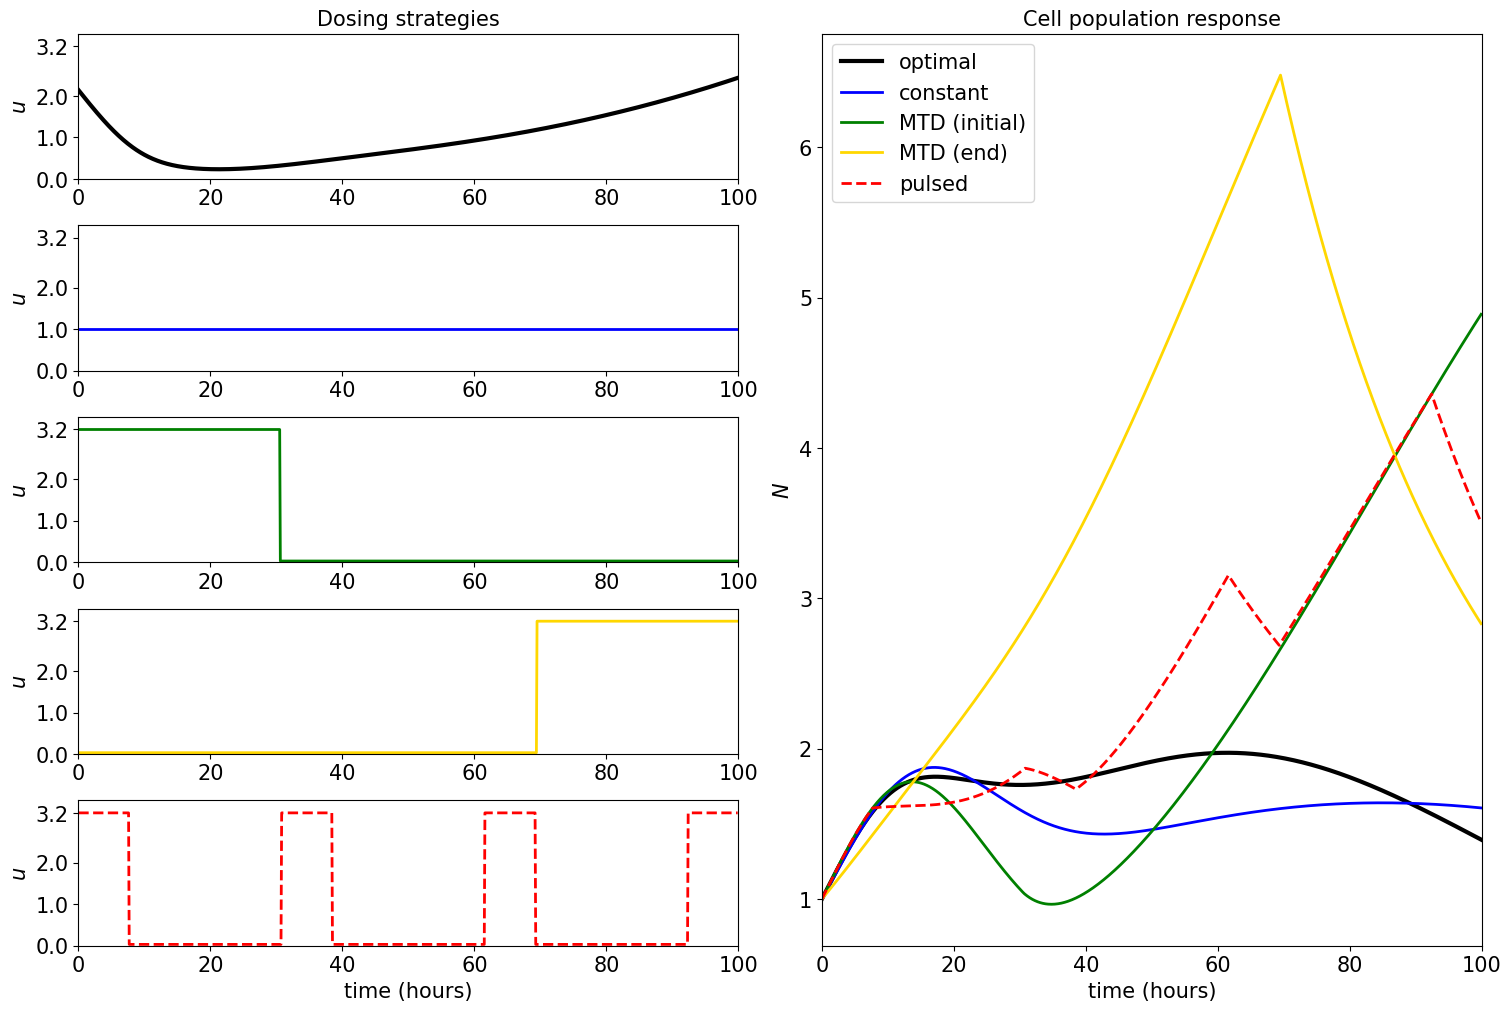

In [15]:
# Try and plot dosing on separate axes using subplot_mosaic

axd = plt.figure(figsize=(15, 10), layout="constrained").subplot_mosaic(
    """
    AF
    BF
    CF
    DF
    EF
    """
)
y_ticks = [0, 1, 2, u_max]
axd['A'].plot(time_vec, u_sol, label='optimal', linewidth=3, color='k')
axd['A'].set_ylim([0, 3.5])
axd['A'].set_xlim([t0, tf])
axd['A'].set_yticks(y_ticks)
axd['A'].set_ylabel(r'$u$')
axd['A'].set_title('Dosing strategies')
axd['B'].plot(time_vec, u_constant_vec, label='constant', linewidth=2, color='b')
axd['B'].set_xlim([t0, tf])
axd['B'].set_ylim([0, 3.5])
axd['B'].set_yticks(y_ticks)
axd['B'].set_ylabel(r'$u$')
axd['C'].plot(time_vec, u_MTD_vec, label='MTD (start on)', linewidth=2, color='g')
axd['C'].set_xlim([t0, tf])
axd['C'].set_ylim([0, 3.5])
axd['C'].set_yticks(y_ticks)
axd['C'].set_ylabel(r'$u$')
axd['D'].plot(time_vec, u_MTD_end_vec, label='MTD (end on)', linewidth=2, color='gold')
axd['D'].set_xlim([t0, tf])
axd['D'].set_ylim([0, 3.5])
axd['D'].set_yticks(y_ticks)
axd['D'].set_ylabel(r'$u$')
axd['E'].plot(time_vec, u_multiple_pulse_vec,  linestyle='--', label='pulsed', linewidth=2, color='r')
axd['E'].set_ylim([0, 3.5])
axd['E'].set_xlim([t0, tf])
axd['E'].set_yticks(y_ticks)
axd['E'].set_ylabel(r'$u$')
axd['E'].set_xlabel('time (hours)')

axd['F'].plot(time_vec, N_sol, label='optimal', linewidth=3, color='k')
axd['F'].plot(time_vec, N_constant, label='constant', linewidth=2, color='b')
axd['F'].plot(time_vec, N_MTD, label='MTD (initial)', linewidth=2, color='g')
axd['F'].plot(time_vec, N_MTD_end, label='MTD (end)', linewidth=2, color='gold')
axd['F'].plot(time_vec, N_multiple_pulse, label='pulsed', linestyle='--', linewidth=2, color='r')
axd['F'].set_xlim([t0, tf])
axd['F'].set_xlabel('time (hours)')
axd['F'].set_ylabel(r'$N$')
axd['F'].set_title('Cell population response')
axd['F'].legend(loc='best')

plt.savefig('optimal_response_comparison_tracking_M_1.png')

plt.show()


In [10]:
N_constant[-1]

1.6065000540923635

In [12]:
N_MTD[-1]

4.890072697638168

In [13]:
N_MTD_end[-1]

2.8320192217311835